In [1]:
!pip install fastai==0.7.0 --no-deps
!pip install torch==0.4.1 torchvision==0.2.1

!pip install anaconda bcolz
!pip install anaconda isoweek
!pip install anaconda pandas-summary



     |████████████████████████████████| 122kB 5.2MB/s 
  Found existing installation: fastai 1.0.57
    Uninstalling fastai-1.0.57:
      Successfully uninstalled fastai-1.0.57
     |████████████████████████████████| 519.5MB 24kB/s 
     |████████████████████████████████| 61kB 24.4MB/s 
ERROR: fastai 0.7.0 requires bcolz, which is not installed.
ERROR: fastai 0.7.0 requires isoweek, which is not installed.
ERROR: fastai 0.7.0 requires pandas-summary, which is not installed.
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 0.4.1 which is incompatible.
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
  Found existing installation: torchvision 0.3.0
    Uninstalling torchvision-0.3.0:
      Successfully uninstalled torchvision-0.3.0
     |████████████████████████████████| 1.5MB 4.2MB/s 
  Created wheel for anaconda: filename=anaconda-0.0.1.1-cp36-none-any.whl size=1124 sha256=183aa9860068333f0cd931be079

In [2]:
#imports
import torch
from bokeh.plotting import figure, show, output_notebook, save, output_file

from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
output_notebook()

#fastai related imports
import fastai
from fastai.learner import *
from fastai.column_data import *
import seaborn as sns
import sklearn.metrics as metrics

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

torch.cuda.is_available()

True

In [3]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

using device: cuda


In [4]:
print(torch.__version__)

0.4.1


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [112]:
path='/content/drive/My Drive/Colab Notebooks/' #path to the dataset
data = pd.read_csv(f'{path}trainset.csv')
print(data.head())

targets_data_names = data['target_id'].tolist()
cmpds_data_names = data['cmpd_id'].tolist()


   Unnamed: 0        cmpd_id target_id  ...  P97612  P51141  P97266
0           1  CHEMBL1232461    P25440  ...   0.104   0.211   0.039
1           2  CHEMBL1232461    O60885  ...   0.044   0.146   0.022
2          10  CHEMBL3645119    P52333  ...   0.181   0.182   0.037
3          11  CHEMBL3645119    P43405  ...   0.239   0.145   0.053
4          13  CHEMBL3645119    P23458  ...   0.150   0.183   0.028

[5 rows x 804 columns]
   Unnamed: 0        cmpd_id target_id  ...  P97612  P51141  P97266
0           4  CHEMBL3669127    P63085  ...   0.041   0.026   0.084
1           5  CHEMBL3669127    P47811  ...   0.208   0.030   0.113
2           6  CHEMBL2386796    Q9UM73  ...   0.107   0.090   0.023
3           7  CHEMBL3605998    P11103  ...   0.140   0.218   0.045
4           8  CHEMBL3669571    O43614  ...   0.013   0.018   0.128

[5 rows x 804 columns]


In [142]:
data.cmpd_id = data.cmpd_id.astype('category').cat.codes.values
data.target_id = data.target_id.astype('category').cat.codes.values

print(data.head())

data = data[['cmpd_id', 'target_id', 'pKd']] #dropping cells .. not needed for this study
print(len(data))


targets_data_names_dict = dict(zip(data.target_id.to_list(),targets_data_names))

   cmpd_id  target_id       pKd
0       25        122  7.000000
1       25         34  7.187087
2      561        191  8.537602
3      561        162  7.008774
4      561        118  8.173925
13786
40218


In [0]:
data.to_csv(f'{path}trainset_codes.csv', sep=',', encoding='utf-8', index=False)

# Collaborative filtering using fastai

In [145]:
val_idxs = get_cv_idxs(len(data)) #get validation indices (default 20% of data)
wd=2e-4 #weight decay
n_factors = 50 #how big embedding matrix we want
len(val_idxs)

2757

In [0]:
cf = CollabFilterDataset.from_csv(path, 'trainset_codes.csv', 'cmpd_id', 'target_id', 'pKd') #creating a custom dataloader
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam) #create a learner (model) and specify the batch size and optimizer

In [147]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2, use_wd_sched=True) #training with learning rate as 1e-2

epoch      trn_loss   val_loss   
    0      0.740797   0.632312  
    1      0.424722   0.496036  
    2      0.172169   0.472292  



[0.47229190237244534]

In [148]:
preds = learn.predict() #this will predict ratings for validation dataset
preds

array([7.65845, 6.89813, 5.85603, ..., 6.67412, 6.43974, 7.31783], dtype=float32)

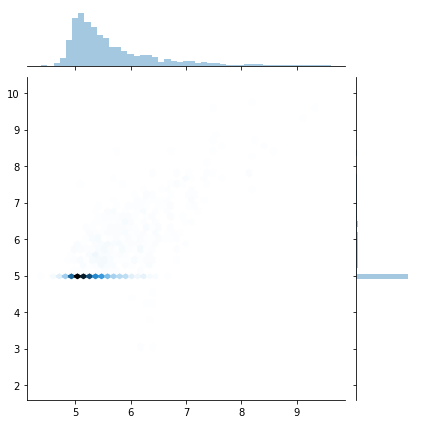

In [149]:
y=learn.data.val_y #actual ratings for validation
sns.jointplot(preds, y, kind='hex', stat_func=None);

In [150]:
math.sqrt(metrics.mean_squared_error(y,preds)) #RMSE for validation data

0.6872349574974254

## Interpreting embeddings and biases

In [0]:
from sklearn.manifold import TSNE

In [220]:

g=data.groupby('target_id')['pKd'].count() #counting the number of interactions for each targets
topTargets=g.sort_values(ascending=False).index.values[:500] #top 3000 targets based on number of ratings
topTargetsIdx = np.array([cf.item2idx[o] for o in topTargets]) #id for the top targets to link it to the embedding and bias matrix created by the model

len(topTargets)

442

In [221]:
m=learn.model; m.cuda()

EmbeddingDotBias(
  (u): Embedding(789, 50)
  (i): Embedding(442, 50)
  (ub): Embedding(789, 1)
  (ib): Embedding(442, 1)
)

In [222]:
target_emb = to_np(m.i(V(topTargetsIdx))) #converting the torch embedding to numpy matrix
target_emb.shape

(442, 50)

In [223]:
#t-sne on embedding vectors
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000,learning_rate=10)
tsne_results = tsne.fit_transform(target_emb)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 442 samples in 0.001s...
[t-SNE] Computed neighbors for 442 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 442 / 442
[t-SNE] Mean sigma: 0.307128
[t-SNE] KL divergence after 50 iterations with early exaggeration: 58.720387
[t-SNE] KL divergence after 1000 iterations: 1.015008


In [157]:
topTargets

array([359,  16, 294, 199, 237,  96, 345,  55,  60, 300, 145, 137, 425,  54,  51, 281, 113,  87, 143, 154,
        61, 126, 191, 121, 153,  67, 118,  33,  35, 287,  76,  17, 155,  80, 132,  38, 165,  99, 427, 251,
       258, 164, 157, 138, 131, 162, 134, 241,  89, 158, 255,  63,  58, 422,  39, 244,  74, 198, 175, 197,
       181,  79, 185, 243, 382, 397,  52, 395, 214,  66, 344, 350, 111, 246, 267, 144, 391, 180, 417, 337,
       160, 332, 117, 257,  71, 140, 194, 142, 254, 240, 103, 231, 302, 273, 222,  81, 224, 400, 373, 405,
       161, 229, 310, 364, 128, 410, 408, 284,  18, 177, 274, 271, 277, 147, 268, 148, 275, 146, 282, 266,
       265, 279, 233, 263, 179,  34, 167, 173, 176, 178, 204, 201, 149, 200, 195, 182, 183, 188, 187, 216,
       217, 218, 440, 225, 226,  40,  30, 230, 232, 234,  28, 238,  26, 247, 151, 261, 283, 313, 285, 356,
       387, 385, 381, 380, 379, 378, 377, 376,  90,  93,  94, 370,  97, 367, 366, 100, 286, 361, 360,  13,
       389, 390, 415, 438, 437, 436, 

In [158]:
targets_data_names_dict

{0: 'A0A072ZLE6',
 1: 'A3EZI9',
 2: 'O00141',
 3: 'O00238',
 4: 'O00329',
 5: 'O00444',
 6: 'O00506',
 7: 'O00519',
 8: 'O00750',
 9: 'O00763',
 10: 'O14578',
 11: 'O14730',
 12: 'O14733',
 13: 'O14757',
 14: 'O14920',
 15: 'O14936',
 16: 'O14965',
 17: 'O14976',
 18: 'O15075',
 19: 'O15111',
 20: 'O15146',
 21: 'O15197',
 22: 'O15264',
 23: 'O15294',
 24: 'O15530',
 25: 'O43283',
 26: 'O43293',
 27: 'O43318',
 28: 'O43353',
 29: 'O43683',
 30: 'O60285',
 31: 'O60331',
 32: 'O60341',
 33: 'O60674',
 34: 'O60885',
 35: 'O75116',
 36: 'O75385',
 37: 'O75460',
 38: 'O75582',
 39: 'O75676',
 40: 'O75716',
 41: 'O75747',
 42: 'O75914',
 43: 'O76039',
 44: 'O94768',
 45: 'O94804',
 46: 'O94806',
 47: 'O94921',
 48: 'O95382',
 49: 'O95696',
 50: 'O95747',
 51: 'O95819',
 52: 'O96013',
 53: 'O96017',
 54: 'P00519',
 55: 'P00533',
 56: 'P03428',
 57: 'P04035',
 58: 'P04049',
 59: 'P04062',
 60: 'P04626',
 61: 'P04629',
 62: 'P05067',
 63: 'P05106',
 64: 'P05107',
 65: 'P05362',
 66: 'P06213',
 

In [160]:
#preparing dataframe for visualization
df_combine = pd.DataFrame([targets_data_names_dict[i] for i in topTargets])
df_combine.columns = ['title']
df_combine['x-tsne'] = tsne_results[:,0]
df_combine['y-tsne'] = tsne_results[:,1]
df_combine.head()

,title,x-tsne,y-tsne
0,Q96GD4,3.372170,6.705224
1,O14965,3.805724,6.293725
2,Q16539,1.061040,0.569827
3,P53779,-17.565062,-3.511137
4,Q05397,8.408521,9.649380


In [0]:
df_combine.to_csv(f'{path}tsne-2comp.csv')

### **Visualizing t-SNE components of embeddings using Bokeh**

In [0]:
source = ColumnDataSource(dict(
    x=df_combine['x-tsne'],
    y=df_combine['y-tsne'],
    title= df_combine['title']
))

In [163]:
import plotly as py

#output_file('t-SNE_emb.html')

title = 'T-SNE visualization of embeddings'

plot_lda = figure(plot_width=1000, plot_height=600,
                         title=title, tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                         x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x='x', y='y',source=source,
                    alpha=0.4, size=10)

show(plot_lda)

#save(plot_lda, 't-SNE_emb.html') #this will save the plot as html

#save(plot_lda, f'{path}t-SNE_emb.html')

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "Title: @title"}
    


### Cosine similarity in embedding space


In [0]:
def cos_sim(a, b):
	"""Takes 2 vectors a, b and returns the cosine similarity according 
	to the definition of the dot product
	"""
	dot_product = np.dot(a, b)
	norm_a = np.linalg.norm(a)
	norm_b = np.linalg.norm(b)
	return dot_product / (norm_a * norm_b)

In [167]:
title2emb = pd.DataFrame([targets_data_names_dict[i] for i in topTargets])
title2emb.columns = ['title']
title2emb = pd.concat([title2emb,pd.DataFrame(target_emb)],axis =1)
title2emb.head()

,title,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,Q96GD4,0.040618,-0.239584,-0.113838,-0.063108,0.176904,0.124862,-0.051422,0.018587,-0.062328,-0.007567,0.008459,-0.008099,0.139846,-0.249541,0.279150,0.022390,-0.081961,-0.087444,0.054047,0.064750,0.325451,0.009326,-0.028395,0.096303,0.161403,0.076738,0.038015,-0.046819,-0.094794,0.029681,-0.170451,-0.131579,0.215251,0.002111,0.021284,0.208969,-0.194350,-0.038415,0.152984,0.026477,0.105019,0.048910,0.045213,-0.151949,0.125799,0.183875,-0.079947,0.020228,0.014080,0.172852
1,O14965,0.107619,-0.126103,-0.088048,-0.138256,0.087191,0.047160,0.023934,0.016396,0.008694,-0.014250,-0.025814,-0.060227,0.145669,-0.101865,0.200008,0.067494,-0.015801,-0.018726,0.103398,-0.044993,0.372666,-0.162490,0.012558,0.004752,0.081284,0.051923,-0.016805,0.020655,0.031008,0.038670,-0.221110,0.001481,0.195222,-0.015103,0.056258,0.174727,-0.211807,0.057671,0.183013,-0.151831,0.108071,-0.047952,0.063899,-0.199123,-0.029673,0.206876,0.153380,0.179349,0.132932,0.133903
2,Q16539,0.212943,-0.062327,-0.067453,-0.078195,0.099350,0.145037,0.238188,0.270717,0.096397,-0.191058,-0.208893,-0.018312,0.062163,-0.216152,0.012953,-0.177495,-0.103162,-0.251415,0.251008,-0.200069,0.080333,0.040643,0.205904,-0.036510,-0.302632,-0.060303,0.167292,-0.002992,-0.268981,-0.028344,-0.021633,0.031312,0.079004,0.005009,-0.202668,0.104757,-0.089976,0.120178,0.002669,0.148782,-0.006586,0.267159,-0.188850,-0.238157,0.019756,0.233869,0.035875,0.468933,0.154120,0.229343
3,P53779,0.268973,0.082557,-0.030428,0.187229,-0.018210,0.256209,0.164858,0.129116,0.092582,-0.019960,-0.122207,0.050856,0.168919,-0.041000,0.007336,-0.086445,-0.085446,0.011603,0.172662,-0.075178,-0.009839,0.249376,0.164775,-0.418747,0.065384,0.202317,0.060700,0.013737,-0.068673,-0.060543,-0.129371,0.029659,-0.021115,-0.018165,-0.235424,0.020446,0.099965,-0.005544,-0.158603,0.087351,0.149250,0.200168,-0.251192,-0.049883,-0.012538,0.032647,-0.033794,0.087829,0.040037,0.189259
4,Q05397,-0.013449,-0.117195,0.024251,-0.221247,0.001986,0.045691,0.144344,0.006017,-0.052418,0.099806,-0.141752,0.028545,0.257357,-0.135849,0.085036,0.115512,0.169094,0.088195,0.172292,-0.019558,0.055563,-0.130701,-0.335964,0.151903,0.052605,0.184507,0.022698,-0.198100,-0.249341,0.012936,-0.136841,-0.004420,-0.058424,-0.196807,-0.006812,0.053814,-0.140708,0.094944,0.040092,-0.209502,0.120616,-0.009519,0.120684,-0.062696,0.179400,0.074426,0.120627,-0.218444,0.006521,0.234318


In [182]:
title2emb['title'].values[300]

'Q92630'

In [183]:
base_target = title2emb['title'].values[300]
base_emb = title2emb[title2emb['title']==base_target].iloc[:,1:].values #embedding vector for the base target
target_list = title2emb.title
cos_sim_dict = {i:cos_sim(np.squeeze(base_emb),np.squeeze(title2emb[title2emb['title']==i].iloc[:,1:].values)) for i in target_list}
sorted(cos_sim_dict.items(), key=itemgetter(1),reverse=True)[:15] #targets sorted by cosine similarity to the base target

[('Q92630', 1.0),
 ('Q16566', 0.7393151),
 ('O15111', 0.7096392),
 ('Q13627', 0.704812),
 ('P57078', 0.6948824),
 ('P78368', 0.6768457),
 ('P51957', 0.6422096),
 ('Q96NX5', 0.62884736),
 ('Q8IWQ3', 0.6143532),
 ('O43293', 0.61366665),
 ('P46734', 0.6129475),
 ('O14920', 0.61033547),
 ('O14965', 0.6045033),
 ('P36897', 0.60023844),
 ('O15146', 0.5912686)]

### Target bias

In [0]:
target_bias = to_np(m.ib(V(topTargetsIdx))) #extracting the target bias from the trained model for 3000 targets


In [0]:
target_pKd = [(b[0], targets_data_names_dict[i]) for i,b in zip(topTargets,target_bias)]

In [192]:
sorted(target_pKd, key=lambda o: o[0])[:15] #worst targets based on bias pKd

[(-0.39894208, 'Q7KQK5'),
 (-0.3977154, 'P43490'),
 (-0.38591787, 'P42345'),
 (-0.36751524, 'P28482'),
 (-0.3667812, 'O15294'),
 (-0.33652207, 'Q8TBX8'),
 (-0.33436295, 'P53779'),
 (-0.33339733, 'P98170'),
 (-0.32455873, 'O95819'),
 (-0.32206935, 'Q16236'),
 (-0.32175055, 'P24941'),
 (-0.29269135, 'Q9Y251'),
 (-0.27541646, 'P42336'),
 (-0.27417418, 'P42680'),
 (-0.25602597, 'Q9NY57')]

In [193]:
sorted(target_pKd, key=lambda o: o[0], reverse=True)[:15] #top targets based on bias pKd

[(0.3702418, 'P05106'),
 (0.25709388, 'P47811'),
 (0.12870046, 'Q63844'),
 (0.12847367, 'P30969'),
 (0.12812696, 'P05067'),
 (0.125127, 'P97612'),
 (0.117452785, 'P00533'),
 (0.10373512, 'Q9JI10'),
 (0.092813, 'P09619'),
 (0.09072893, 'Q96GD4'),
 (0.07136395, 'Q63707'),
 (0.0677859, 'O75116'),
 (0.06743367, 'P04035'),
 (0.065376334, 'P36888'),
 (0.060041014, 'P04626')]

### Looking at a particular compound

In [197]:
u=data.groupby('cmpd_id')['pKd'].count()
topcmpds=u.sort_values(ascending=False).index.values[:100]
topcmpds_idx = np.array([cf.user2idx[o] for o in topcmpds])

topcmpds

array([725, 722, 715, 265, 740, 732, 704,  24,  22,  19, 360, 723, 755, 694, 711, 710, 697, 680,  88, 152,
       700, 359,  33, 739, 358,   3, 784, 427, 376, 786,   0,   2, 153, 758,  59, 208, 215,  12,  23, 554,
       491, 717, 221, 714, 222, 253,  13, 252, 270, 269, 268, 199, 532, 693,  69, 331,  26, 563, 533, 626,
       186, 195, 200, 498,   1, 299,  11, 561, 551, 628, 629, 335, 630, 555, 632, 633,  15, 634, 553, 552,
       625, 550,  14,  98, 640,  75, 107,  80, 372, 677, 105, 676, 104, 497,  99, 202, 103, 102, 101, 108])

In [0]:
p = 725

cmpd_p = data[data['cmpd_id']==p] #cmpd with the highest number of interactions
uptarget_idx = np.array([cf.item2idx[o] for o in cmpd_p.target_id]) #id for the top targets to link it to the embedding and bias matrix created by the model
up_pKd = cmpd_p.pKd
target_emb_up = to_np(m.i(V(uptarget_idx))) #converting the torch embedding to numpy matrix

In [0]:
df_combine_up = pd.DataFrame([targets_data_names_dict[i] for i in cmpd_p.target_id])
df_combine_up.columns = ['title']
df_combine_up = pd.concat([df_combine_up,pd.DataFrame(target_emb_up)],axis=1)

In [226]:
df_combine_up.head()

,title,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,Q9UKE5,-0.130195,0.011442,0.171644,-0.068230,0.078711,-0.106864,0.069110,0.099751,-0.107127,-0.080754,-0.001443,-0.342099,0.215872,0.117764,0.023385,0.191228,0.002243,0.120536,0.007209,0.006515,0.003199,0.193869,0.206762,0.105516,0.000600,-0.220158,0.064303,0.230395,-0.262119,-0.017409,0.038737,-0.044117,-0.034908,-0.121648,-0.048576,0.072929,-0.048254,-0.054549,0.029716,0.142071,-0.295658,-0.008625,0.039996,-0.124800,0.089010,-0.068255,0.058985,-0.011129,0.089657,-0.013033
1,Q9Y6R4,0.171487,-0.154425,-0.045344,-0.108630,-0.031694,0.049529,-0.063266,0.135267,-0.112419,-0.009914,0.187751,-0.189039,-0.113845,-0.128483,0.116895,0.086206,-0.058012,0.100994,0.128902,-0.299386,0.127021,-0.059514,0.152906,0.173825,0.086500,-0.092363,-0.196811,-0.054750,-0.287394,0.102971,-0.029332,-0.173031,0.060713,0.222121,-0.037286,0.027212,-0.061366,0.127077,-0.019024,0.107993,0.064181,0.159894,-0.037075,0.000366,-0.037036,0.086791,0.192462,-0.009585,0.145799,0.104169
2,Q9Y6M4,0.002999,-0.103783,0.013625,0.071645,-0.127808,-0.149618,0.148507,0.232114,-0.210274,-0.062640,-0.211967,-0.025587,0.061125,0.060062,0.173350,0.047550,0.041705,-0.087173,0.295650,0.028192,-0.028214,0.101668,-0.008651,-0.043939,0.150457,0.029762,0.323966,0.496601,0.067002,0.053840,0.042430,0.005605,0.000324,-0.107129,0.201530,0.161181,-0.173063,-0.044127,0.043050,-0.042366,-0.015620,0.030031,0.138871,-0.199092,-0.108047,0.137658,0.168731,-0.054224,0.136014,0.131492
3,Q9Y6E0,0.061987,-0.134613,-0.109080,-0.072955,0.048406,0.013891,0.119345,0.136823,-0.020089,-0.200768,-0.022857,-0.411794,0.201004,-0.076573,-0.017656,0.115329,0.032017,0.239547,0.242676,-0.084292,-0.024454,0.051569,0.153394,0.095301,0.314064,0.087312,-0.092309,0.034548,-0.292928,0.130659,0.044058,-0.168315,-0.048207,0.111010,0.272795,0.110370,-0.117934,-0.031015,0.088678,0.250230,-0.084120,0.069629,-0.061645,-0.079516,-0.112683,0.054892,0.217514,-0.018917,0.124540,0.054631
4,Q9Y616,-0.002482,-0.003815,-0.022119,-0.034569,0.044538,0.051729,-0.151597,0.087780,-0.010957,0.033750,-0.006126,0.115423,-0.060819,0.003252,0.205610,0.205534,-0.045592,0.012573,0.033743,-0.049513,0.242205,-0.179034,0.039974,0.025044,0.073745,0.209066,0.055093,0.003750,0.137129,-0.017321,0.032459,-0.111798,0.113664,0.034875,-0.042865,0.138940,-0.202627,-0.030949,0.056472,0.165345,-0.025032,-0.096803,0.107600,-0.219589,-0.205377,0.096843,-0.044902,-0.086100,0.034476,0.015733


In [227]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000,learning_rate=10)
tsne_results = tsne.fit_transform(target_emb_up)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 374 samples in 0.002s...
[t-SNE] Computed neighbors for 374 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 374 / 374
[t-SNE] Mean sigma: 0.300811
[t-SNE] KL divergence after 50 iterations with early exaggeration: 57.116833
[t-SNE] KL divergence after 1000 iterations: 1.004666


In [228]:
df_combine_up['x-tsne'] = tsne_results[:,0]
df_combine_up['y-tsne'] = tsne_results[:,1]
df_combine_up.head()

,title,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,x-tsne,y-tsne
0,Q9UKE5,-0.130195,0.011442,0.171644,-0.068230,0.078711,-0.106864,0.069110,0.099751,-0.107127,-0.080754,-0.001443,-0.342099,0.215872,0.117764,0.023385,0.191228,0.002243,0.120536,0.007209,0.006515,0.003199,0.193869,0.206762,0.105516,0.000600,-0.220158,0.064303,0.230395,-0.262119,-0.017409,0.038737,-0.044117,-0.034908,-0.121648,-0.048576,0.072929,-0.048254,-0.054549,0.029716,0.142071,-0.295658,-0.008625,0.039996,-0.124800,0.089010,-0.068255,0.058985,-0.011129,0.089657,-0.013033,-0.571718,-17.960474
1,Q9Y6R4,0.171487,-0.154425,-0.045344,-0.108630,-0.031694,0.049529,-0.063266,0.135267,-0.112419,-0.009914,0.187751,-0.189039,-0.113845,-0.128483,0.116895,0.086206,-0.058012,0.100994,0.128902,-0.299386,0.127021,-0.059514,0.152906,0.173825,0.086500,-0.092363,-0.196811,-0.054750,-0.287394,0.102971,-0.029332,-0.173031,0.060713,0.222121,-0.037286,0.027212,-0.061366,0.127077,-0.019024,0.107993,0.064181,0.159894,-0.037075,0.000366,-0.037036,0.086791,0.192462,-0.009585,0.145799,0.104169,-12.309137,1.899520
2,Q9Y6M4,0.002999,-0.103783,0.013625,0.071645,-0.127808,-0.149618,0.148507,0.232114,-0.210274,-0.062640,-0.211967,-0.025587,0.061125,0.060062,0.173350,0.047550,0.041705,-0.087173,0.295650,0.028192,-0.028214,0.101668,-0.008651,-0.043939,0.150457,0.029762,0.323966,0.496601,0.067002,0.053840,0.042430,0.005605,0.000324,-0.107129,0.201530,0.161181,-0.173063,-0.044127,0.043050,-0.042366,-0.015620,0.030031,0.138871,-0.199092,-0.108047,0.137658,0.168731,-0.054224,0.136014,0.131492,-1.848083,4.993517
3,Q9Y6E0,0.061987,-0.134613,-0.109080,-0.072955,0.048406,0.013891,0.119345,0.136823,-0.020089,-0.200768,-0.022857,-0.411794,0.201004,-0.076573,-0.017656,0.115329,0.032017,0.239547,0.242676,-0.084292,-0.024454,0.051569,0.153394,0.095301,0.314064,0.087312,-0.092309,0.034548,-0.292928,0.130659,0.044058,-0.168315,-0.048207,0.111010,0.272795,0.110370,-0.117934,-0.031015,0.088678,0.250230,-0.084120,0.069629,-0.061645,-0.079516,-0.112683,0.054892,0.217514,-0.018917,0.124540,0.054631,16.087557,-5.143065
4,Q9Y616,-0.002482,-0.003815,-0.022119,-0.034569,0.044538,0.051729,-0.151597,0.087780,-0.010957,0.033750,-0.006126,0.115423,-0.060819,0.003252,0.205610,0.205534,-0.045592,0.012573,0.033743,-0.049513,0.242205,-0.179034,0.039974,0.025044,0.073745,0.209066,0.055093,0.003750,0.137129,-0.017321,0.032459,-0.111798,0.113664,0.034875,-0.042865,0.138940,-0.202627,-0.030949,0.056472,0.165345,-0.025032,-0.096803,0.107600,-0.219589,-0.205377,0.096843,-0.044902,-0.086100,0.034476,0.015733,-4.926057,-7.818250


In [229]:
df_combine_up['pKd'] = cmpd_p.pKd.reset_index()['pKd']
df_combine_up.head()

,title,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,x-tsne,y-tsne,pKd
0,Q9UKE5,-0.130195,0.011442,0.171644,-0.068230,0.078711,-0.106864,0.069110,0.099751,-0.107127,-0.080754,-0.001443,-0.342099,0.215872,0.117764,0.023385,0.191228,0.002243,0.120536,0.007209,0.006515,0.003199,0.193869,0.206762,0.105516,0.000600,-0.220158,0.064303,0.230395,-0.262119,-0.017409,0.038737,-0.044117,-0.034908,-0.121648,-0.048576,0.072929,-0.048254,-0.054549,0.029716,0.142071,-0.295658,-0.008625,0.039996,-0.124800,0.089010,-0.068255,0.058985,-0.011129,0.089657,-0.013033,-0.571718,-17.960474,7.602060
1,Q9Y6R4,0.171487,-0.154425,-0.045344,-0.108630,-0.031694,0.049529,-0.063266,0.135267,-0.112419,-0.009914,0.187751,-0.189039,-0.113845,-0.128483,0.116895,0.086206,-0.058012,0.100994,0.128902,-0.299386,0.127021,-0.059514,0.152906,0.173825,0.086500,-0.092363,-0.196811,-0.054750,-0.287394,0.102971,-0.029332,-0.173031,0.060713,0.222121,-0.037286,0.027212,-0.061366,0.127077,-0.019024,0.107993,0.064181,0.159894,-0.037075,0.000366,-0.037036,0.086791,0.192462,-0.009585,0.145799,0.104169,-12.309137,1.899520,5.318759
2,Q9Y6M4,0.002999,-0.103783,0.013625,0.071645,-0.127808,-0.149618,0.148507,0.232114,-0.210274,-0.062640,-0.211967,-0.025587,0.061125,0.060062,0.173350,0.047550,0.041705,-0.087173,0.295650,0.028192,-0.028214,0.101668,-0.008651,-0.043939,0.150457,0.029762,0.323966,0.496601,0.067002,0.053840,0.042430,0.005605,0.000324,-0.107129,0.201530,0.161181,-0.173063,-0.044127,0.043050,-0.042366,-0.015620,0.030031,0.138871,-0.199092,-0.108047,0.137658,0.168731,-0.054224,0.136014,0.131492,-1.848083,4.993517,6.619789
3,Q9Y6E0,0.061987,-0.134613,-0.109080,-0.072955,0.048406,0.013891,0.119345,0.136823,-0.020089,-0.200768,-0.022857,-0.411794,0.201004,-0.076573,-0.017656,0.115329,0.032017,0.239547,0.242676,-0.084292,-0.024454,0.051569,0.153394,0.095301,0.314064,0.087312,-0.092309,0.034548,-0.292928,0.130659,0.044058,-0.168315,-0.048207,0.111010,0.272795,0.110370,-0.117934,-0.031015,0.088678,0.250230,-0.084120,0.069629,-0.061645,-0.079516,-0.112683,0.054892,0.217514,-0.018917,0.124540,0.054631,16.087557,-5.143065,7.200659
4,Q9Y616,-0.002482,-0.003815,-0.022119,-0.034569,0.044538,0.051729,-0.151597,0.087780,-0.010957,0.033750,-0.006126,0.115423,-0.060819,0.003252,0.205610,0.205534,-0.045592,0.012573,0.033743,-0.049513,0.242205,-0.179034,0.039974,0.025044,0.073745,0.209066,0.055093,0.003750,0.137129,-0.017321,0.032459,-0.111798,0.113664,0.034875,-0.042865,0.138940,-0.202627,-0.030949,0.056472,0.165345,-0.025032,-0.096803,0.107600,-0.219589,-0.205377,0.096843,-0.044902,-0.086100,0.034476,0.015733,-4.926057,-7.818250,6.026872


In [0]:
df_combine_up.to_csv(f'{path}tsne_2comp_up.csv')

### Visualizing t-SNE components of embeddings using Bokeh

In [0]:
df_combine_up['pKd_bin'] = pd.cut(df_combine_up.pKd,5,labels=[0,1,2,3,4]) #creating bins from the ratings

In [232]:
df_combine_up.head()

,title,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,x-tsne,y-tsne,pKd,pKd_bin
0,Q9UKE5,-0.130195,0.011442,0.171644,-0.068230,0.078711,-0.106864,0.069110,0.099751,-0.107127,-0.080754,-0.001443,-0.342099,0.215872,0.117764,0.023385,0.191228,0.002243,0.120536,0.007209,0.006515,0.003199,0.193869,0.206762,0.105516,0.000600,-0.220158,0.064303,0.230395,-0.262119,-0.017409,0.038737,-0.044117,-0.034908,-0.121648,-0.048576,0.072929,-0.048254,-0.054549,0.029716,0.142071,-0.295658,-0.008625,0.039996,-0.124800,0.089010,-0.068255,0.058985,-0.011129,0.089657,-0.013033,-0.571718,-17.960474,7.602060,2
1,Q9Y6R4,0.171487,-0.154425,-0.045344,-0.108630,-0.031694,0.049529,-0.063266,0.135267,-0.112419,-0.009914,0.187751,-0.189039,-0.113845,-0.128483,0.116895,0.086206,-0.058012,0.100994,0.128902,-0.299386,0.127021,-0.059514,0.152906,0.173825,0.086500,-0.092363,-0.196811,-0.054750,-0.287394,0.102971,-0.029332,-0.173031,0.060713,0.222121,-0.037286,0.027212,-0.061366,0.127077,-0.019024,0.107993,0.064181,0.159894,-0.037075,0.000366,-0.037036,0.086791,0.192462,-0.009585,0.145799,0.104169,-12.309137,1.899520,5.318759,0
2,Q9Y6M4,0.002999,-0.103783,0.013625,0.071645,-0.127808,-0.149618,0.148507,0.232114,-0.210274,-0.062640,-0.211967,-0.025587,0.061125,0.060062,0.173350,0.047550,0.041705,-0.087173,0.295650,0.028192,-0.028214,0.101668,-0.008651,-0.043939,0.150457,0.029762,0.323966,0.496601,0.067002,0.053840,0.042430,0.005605,0.000324,-0.107129,0.201530,0.161181,-0.173063,-0.044127,0.043050,-0.042366,-0.015620,0.030031,0.138871,-0.199092,-0.108047,0.137658,0.168731,-0.054224,0.136014,0.131492,-1.848083,4.993517,6.619789,1
3,Q9Y6E0,0.061987,-0.134613,-0.109080,-0.072955,0.048406,0.013891,0.119345,0.136823,-0.020089,-0.200768,-0.022857,-0.411794,0.201004,-0.076573,-0.017656,0.115329,0.032017,0.239547,0.242676,-0.084292,-0.024454,0.051569,0.153394,0.095301,0.314064,0.087312,-0.092309,0.034548,-0.292928,0.130659,0.044058,-0.168315,-0.048207,0.111010,0.272795,0.110370,-0.117934,-0.031015,0.088678,0.250230,-0.084120,0.069629,-0.061645,-0.079516,-0.112683,0.054892,0.217514,-0.018917,0.124540,0.054631,16.087557,-5.143065,7.200659,2
4,Q9Y616,-0.002482,-0.003815,-0.022119,-0.034569,0.044538,0.051729,-0.151597,0.087780,-0.010957,0.033750,-0.006126,0.115423,-0.060819,0.003252,0.205610,0.205534,-0.045592,0.012573,0.033743,-0.049513,0.242205,-0.179034,0.039974,0.025044,0.073745,0.209066,0.055093,0.003750,0.137129,-0.017321,0.032459,-0.111798,0.113664,0.034875,-0.042865,0.138940,-0.202627,-0.030949,0.056472,0.165345,-0.025032,-0.096803,0.107600,-0.219589,-0.205377,0.096843,-0.044902,-0.086100,0.034476,0.015733,-4.926057,-7.818250,6.026872,1


In [0]:
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 3: 'red', 4: 'black'} #assigning colors for each bin

In [0]:
df_combine_up['colors'] = df_combine_up['pKd_bin'].apply(lambda l: cluster_colors[l]) #creating color column in the df

In [235]:
df_combine_up.head()

,title,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,x-tsne,y-tsne,pKd,pKd_bin,colors
0,Q9UKE5,-0.130195,0.011442,0.171644,-0.068230,0.078711,-0.106864,0.069110,0.099751,-0.107127,-0.080754,-0.001443,-0.342099,0.215872,0.117764,0.023385,0.191228,0.002243,0.120536,0.007209,0.006515,0.003199,0.193869,0.206762,0.105516,0.000600,-0.220158,0.064303,0.230395,-0.262119,-0.017409,0.038737,-0.044117,-0.034908,-0.121648,-0.048576,0.072929,-0.048254,-0.054549,0.029716,0.142071,-0.295658,-0.008625,0.039996,-0.124800,0.089010,-0.068255,0.058985,-0.011129,0.089657,-0.013033,-0.571718,-17.960474,7.602060,2,yellow
1,Q9Y6R4,0.171487,-0.154425,-0.045344,-0.108630,-0.031694,0.049529,-0.063266,0.135267,-0.112419,-0.009914,0.187751,-0.189039,-0.113845,-0.128483,0.116895,0.086206,-0.058012,0.100994,0.128902,-0.299386,0.127021,-0.059514,0.152906,0.173825,0.086500,-0.092363,-0.196811,-0.054750,-0.287394,0.102971,-0.029332,-0.173031,0.060713,0.222121,-0.037286,0.027212,-0.061366,0.127077,-0.019024,0.107993,0.064181,0.159894,-0.037075,0.000366,-0.037036,0.086791,0.192462,-0.009585,0.145799,0.104169,-12.309137,1.899520,5.318759,0,blue
2,Q9Y6M4,0.002999,-0.103783,0.013625,0.071645,-0.127808,-0.149618,0.148507,0.232114,-0.210274,-0.062640,-0.211967,-0.025587,0.061125,0.060062,0.173350,0.047550,0.041705,-0.087173,0.295650,0.028192,-0.028214,0.101668,-0.008651,-0.043939,0.150457,0.029762,0.323966,0.496601,0.067002,0.053840,0.042430,0.005605,0.000324,-0.107129,0.201530,0.161181,-0.173063,-0.044127,0.043050,-0.042366,-0.015620,0.030031,0.138871,-0.199092,-0.108047,0.137658,0.168731,-0.054224,0.136014,0.131492,-1.848083,4.993517,6.619789,1,green
3,Q9Y6E0,0.061987,-0.134613,-0.109080,-0.072955,0.048406,0.013891,0.119345,0.136823,-0.020089,-0.200768,-0.022857,-0.411794,0.201004,-0.076573,-0.017656,0.115329,0.032017,0.239547,0.242676,-0.084292,-0.024454,0.051569,0.153394,0.095301,0.314064,0.087312,-0.092309,0.034548,-0.292928,0.130659,0.044058,-0.168315,-0.048207,0.111010,0.272795,0.110370,-0.117934,-0.031015,0.088678,0.250230,-0.084120,0.069629,-0.061645,-0.079516,-0.112683,0.054892,0.217514,-0.018917,0.124540,0.054631,16.087557,-5.143065,7.200659,2,yellow
4,Q9Y616,-0.002482,-0.003815,-0.022119,-0.034569,0.044538,0.051729,-0.151597,0.087780,-0.010957,0.033750,-0.006126,0.115423,-0.060819,0.003252,0.205610,0.205534,-0.045592,0.012573,0.033743,-0.049513,0.242205,-0.179034,0.039974,0.025044,0.073745,0.209066,0.055093,0.003750,0.137129,-0.017321,0.032459,-0.111798,0.113664,0.034875,-0.042865,0.138940,-0.202627,-0.030949,0.056472,0.165345,-0.025032,-0.096803,0.107600,-0.219589,-0.205377,0.096843,-0.044902,-0.086100,0.034476,0.015733,-4.926057,-7.818250,6.026872,1,green


In [0]:
top_labels = {0: 'V. Low', 1:'Low', 2:'Medium', 3:'High',4:'V.High'} #actual range of bins

In [0]:
source = ColumnDataSource(dict(
    x=df_combine_up['x-tsne'],
    y=df_combine_up['y-tsne'],
    title= df_combine_up['title'], #title for tool tip
    colors = df_combine_up['colors'], #colors for each point according to cluster/bin
    label=df_combine_up['pKd_bin'].apply(lambda l: top_labels[l]) #label for each cluster/bin
))

In [238]:
df_combine_up['x-tsne'].shape

(374,)

In [239]:
title = 'T-SNE visualization of embeddings- cluster by cmpd pKd (cmpd_id:725)'

plot_lda = figure(plot_width=1000, plot_height=600,
                     title=title, tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x='x', y='y',source=source,legend='label',
                alpha=0.8, color='colors',)

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "Title: @title"}

plot_lda.legend.location = "top_left"
plot_lda.legend.orientation = "horizontal"
show(plot_lda)


#save(plot_lda, '{}.html'.format(title))

#save(plot_lda, f'{path}t-SNE_cluster_rating.html')

We are looking for relationship between pKd values of the given compound and the embedding vectors of different targets.

We can see that targets which have higher pKd are concentrated in one portion of the embedding space.

Similarly, targets with lower pKd are in another portion of the space.

### Embeddings cluster by bias

Target bias can be considered as a measure of actual closeness of the targets adjusting for the different pKd patterns of different compounds.

Targets which have low (or high) pKd have some characteristics in common which are getting captured by the embeddings.

Targets with similar bias (measure of unbiased interactions as discussed) should be close in embedding space.

In [0]:
df_combine['bias'] = target_bias


In [0]:
df_combine['bias_bin'] = pd.cut(df_combine.bias,5,labels=[0,1,2,3,4])

In [0]:
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 3: 'red', 4: 'black'}

df_combine['colors'] = df_combine['bias_bin'].apply(lambda l: cluster_colors[l])

df_combine.head()

top_labels1 = {0: 'V. Low', 1:'Low', 2:'Medium', 3:'High',4:'V.High'}

In [0]:
df_combine.to_csv(f'{path}tsne_2comp_bias.csv')

In [244]:
source = ColumnDataSource(dict(
    x=df_combine['x-tsne'],
    y=df_combine['y-tsne'],
    title= df_combine['title'],
    colors = df_combine['colors'],
    label=df_combine['bias_bin'].apply(lambda l: top_labels1[l])

))

title = 'T-SNE visualization of embeddings - cluster by bias'

plot_lda = figure(plot_width=1000, plot_height=800,
                     title=title, tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x='x', y='y',source=source,legend='label',
                alpha=0.8, color='colors')

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "Title: @title"}


plot_lda.legend.location = "top_left"

plot_lda.legend.orientation = "horizontal"

show(plot_lda)
#save(plot_lda, 't-SNE_emb_cluster_bias.html')